In [2]:
import gc
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
import sys
# sys.path.append("HateRecognition/target_model/")
from utils import preprocessing, load_anno_data, data_loader, define_target, create_model,get_translated_text,evaluate,forward_pass
from bertopic import BERTopic
from sklearn import preprocessing as pr
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.model_selection import StratifiedKFold
from hdbscan import HDBSCAN
from sklearn.metrics import confusion_matrix
sys.path.append(r"/sise/home/shouei/HateRecognition/target_model/TopicTuner/")
from topictuner import TopicModelTuner as TMT
# torch.cuda.empty_cache()


In [111]:
langs = ["english","spanish","german","franch","russian","chinese"]
file_name = "hatexplain_bt_melted"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with_topic = False

In [85]:
device

device(type='cuda')

In [86]:
df = pd.read_csv(f'../data/ready_data/{file_name}.csv')

In [87]:
df.isna().sum()

Unnamed: 0    0
id            0
target        0
lang          0
text          0
dtype: int64

In [88]:
# df.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [89]:
le = pr.LabelEncoder()
if file_name.endswith("_bt"):
    text = [get_translated_text(x,langs) for i,x in df.iterrows()]
else:
    text = df.text
print(df.target.unique())
labels = le.fit_transform(df.target.values)
unique_labels= list(set(labels))
num_labels= len(unique_labels)

['other' 'Jewish' 'African' 'Islam' 'Homosexual']


In [90]:
le.transform(['African', 'Homosexual', 'Islam', 'Jewish', 'other'])

array([0, 1, 2, 3, 4])

In [112]:
topic_model = None
if with_topic:
    topic_model = BERTopic.load('../target_model/models/topic_model_with_other')
    topics, probs = topic_model.transform(text)
    df['topic'] = topics
    df.topic.hist()

In [92]:
Counter(labels.tolist())

Counter({4: 5985, 3: 6115, 0: 11515, 2: 7687, 1: 2942})

In [93]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    truncation=True
    )

In [113]:
token_id = []
attention_masks = []
MAX_LEN = min(max([len(x.split()) for x in text]),512)
print(MAX_LEN)
encoding_dict = preprocessing(text,tokenizer, MAX_LEN, topic_model)
token_id = encoding_dict['input_ids']
attention_masks = encoding_dict['attention_mask']
labels = torch.tensor(labels)

123


In [95]:
# df = df.iloc[:,1:]

In [96]:
tmp_df = df[['id','target']].groupby(['id','target']).count().reset_index()

In [114]:
n=5
seed = 42
kf = StratifiedKFold(n_splits=n, random_state=seed, shuffle=True)
is_kf = False
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16
# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    tmp_df.id,
    test_size = val_ratio,
    shuffle = True,
    stratify = tmp_df.target)
if is_kf:
    split_range = kf.split(text, labels)
else:
    split_range = [(train_idx, val_idx)]


In [115]:
# !nvidia-smi
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [116]:
train_idx = df[df.id.isin(train_idx)].index
val_idx = df[(df.id.isin(val_idx))&(df.lang.str.startswith('en'))].index
split_range = [(train_idx, val_idx)]

In [117]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [118]:
epochs = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
best_eval_acc = 0
threshold = 0.01
update_model_at_eval = False
for train_idx, val_idx in split_range:
    torch.cuda.empty_cache()
    gc.collect()
    model, optimizer = create_model(num_labels)
    model = model.to(device)
    train_dataloader, validation_dataloader = data_loader(token_id, attention_masks, labels, train_idx, val_idx, batch_size)
    accuracy_scores = {'train':[], 'val':[]}
    losses_scores = {'train':[], 'val':[]}
    for epoch in trange(epochs, desc = 'Epoch'):
        # ========== Training ==========
        # Set model to training mode
        model.train()
        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        # Tracking variables 
        true_labels = []
        pred_labels = []
        tr_loss, true_labels, pred_labels, nb_tr_examples, nb_tr_steps, model = forward_pass(train_dataloader, model, optimizer=optimizer)
        train_evaluation_text = evaluate(tr_loss,true_labels, pred_labels, losses_scores, accuracy_scores, nb_tr_steps, 'train')

        # ========== Validation ==========
        # Set model to evaluation mode
        model.eval()
        # Tracking variables
        eval_loss, nb_eval_examples, nb_eval_steps = 0, 0, 0
        true_labels = []
        pred_labels = []
        if update_model_at_eval:
                eval_loss, true_labels, pred_labels, nb_eval_examples, nb_eval_steps, model = forward_pass(validation_dataloader,model, optimizer=optimizer)
        else:
                # Evaluate data for one epoch
                eval_loss, true_labels, pred_labels, nb_eval_examples, nb_eval_steps, model = forward_pass(validation_dataloader, model, evaluation=True)
        curr_acc = accuracy_score(true_labels, pred_labels)            
        print(f"Epoch {epoch+1}:\n"+train_evaluation_text+evaluate(eval_loss,true_labels, pred_labels, losses_scores, accuracy_scores, nb_eval_steps, 'val'))
        if curr_acc > best_eval_acc:
            best_eval_acc = curr_acc
        elif curr_acc < best_eval_acc - threshold:
            print("Early stopped")
            break
        

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1:
train evaluation
loss = 0.768 accuracy = 0.723, precision = 0.724, recall = 0.683, f1 = 0.699
val evaluation
loss = 0.454 accuracy = 0.854, precision = 0.848, recall = 0.827, f1 = 0.834



Epoch:  25%|██▌       | 2/8 [05:25<16:14, 162.36s/it]

Epoch 2:
train evaluation
loss = 0.448 accuracy = 0.852, precision = 0.843, recall = 0.835, f1 = 0.839
val evaluation
loss = 0.467 accuracy = 0.854, precision = 0.842, recall = 0.833, f1 = 0.836



Epoch:  25%|██▌       | 2/8 [07:56<23:50, 238.48s/it]

Epoch 3:
train evaluation
loss = 0.307 accuracy = 0.901, precision = 0.896, recall = 0.888, f1 = 0.892
val evaluation
loss = 0.525 accuracy = 0.843, precision = 0.825, recall = 0.825, f1 = 0.825

Early stopped


In [119]:
with_topic

False

In [120]:
if with_topic:
    model.save_pretrained(f'models/finetune_topic_other_{file_name}')
else:
    model.save_pretrained(f'models/finetune_plain_{file_name}')    

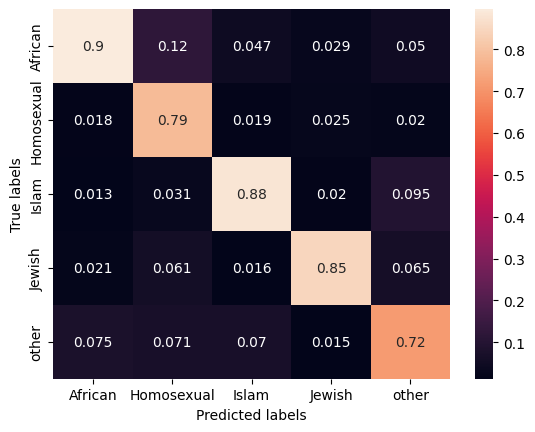

In [121]:
cf_matrix = confusion_matrix(le.inverse_transform(true_labels), le.inverse_transform(pred_labels), labels=le.classes_)
cf_matrix = pd.DataFrame(cf_matrix, columns=le.classes_, index=le.classes_)
import matplotlib.pyplot as plt  
ax= plt.subplot()
sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=1), annot=True, ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 

In [122]:
len(true_labels)

1147

In [123]:
sum([true_labels[i]==pred_labels[i] for i in range(len(true_labels))])/len(true_labels)

0.8430688753269399

In [124]:
# pd.DataFrame(results, columns=['tr_acc', 'val_acc']).mean(axis=0)

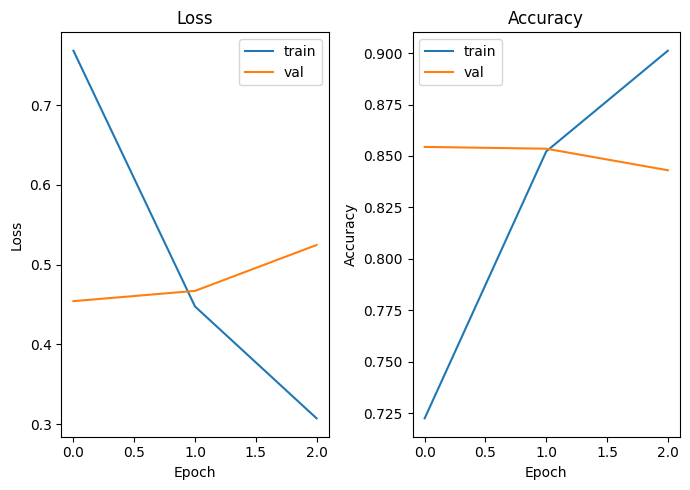

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(losses_scores).plot(title='Loss',figsize=(7,5),xlabel='Epoch', ylabel='Loss', ax=axes[0])
pd.DataFrame(accuracy_scores).plot(title='Accuracy',figsize=(7,5),xlabel='Epoch', ylabel='Accuracy',ax=axes[1])
plt.tight_layout()
plt.savefig(f'loss_acc_curve_{file_name}_with topic={str(with_topic)}.png', dpi=400)

In [58]:
len(df.iloc[val_idx].id.unique())

4282